# Time Series Forecasting

Time is continious. It does not stop, wait or reverse for events. The present is documented, that is why we can look back at events from the past. But is it possible to predict events from the future?

Building a model that predicts future values is a dream of data scientists around the world. What is needed for such a model? And how can you transform data to a peak into the future?

Use will be made of two datasets:

#### Minimum Daily Temperatures (Univariate Dataset)
* DATE: 1981-1990
* TEMP: Daily minimum temperatures in Melbourne, Australia.


#### Ozone Level Detection (Multivariate Dataset)

All the attribute start with T means the temperature measured at different time throughout the day; 

and those starts with WS indicate the wind speed at various time.

* WSR_PK: continuous. peek wind speed -- resultant (meaning average of wind vector)

* WSR_AV: continuous. average wind speed

* T_PK: continuous. Peak T
* T_AV: continuous. Average T
* T85: continuous. T at 850 hpa level (or about 1500 m height)
* RH85: continuous. Relative Humidity at 850 hpa
* U85: continuous. (U wind - east-west direction wind at 850 hpa)
* V85: continuous. V wind - N-S direction wind at 850
* HT85: continuous. Geopotential height at 850 hpa, it is about the same as height at low altitude
* T70: continuous. T at 700 hpa level (roughly 3100 m height)

* RH70: continuous.
* U70: continuous.
* V70: continuous.
* HT70: continuous.

* T50: continuous. T at 500 hpa level (roughly at 5500 m height)

* RH50: continuous.
* U50: continuous.
* V50: continuous.
* HT50: continuous.

* KI: continuous. K-Index 
* TT: continuous. T-Totals
* SLP: continuous. Sea level pressure
* SLP_: continuous. SLP change from previous day

* Precp: continuous. -- precipitation

The data from both sets will be analysed and ARIMA, SARIMA or SARIMAX forecasting algorithms will be applied. (hyper)paramaters will be tuned and a best fitting model will be chosen. 

## Importing Libraries & Datasets

In [10]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import sklearn as sk

print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sk.__version__)
print('matplotlib version:', mpl.__version__)

numpy version: 1.20.1
pandas version: 1.2.4
scikit-learn version: 0.24.1
matplotlib version: 3.3.4


Importing the Daily Minimum Temperatures Dataset

In [11]:
temp_columns = ['DATE', 'TEMP']
temp = pd.read_csv('/Users/matt/Desktop/AI/PersonalNotebooks/ML/TimeSeriesForecasting/daily-min-temperatures.csv',
                     names = temp_columns).iloc[1:, :]
temp_df = temp
temp_df

,DATE,TEMP
1,1981-01-01,20.7
2,1981-01-02,17.9
3,1981-01-03,18.8
4,1981-01-04,14.6
5,1981-01-05,15.8
...,...,...
3646,1990-12-27,14.0
3647,1990-12-28,13.6
3648,1990-12-29,13.5
3649,1990-12-30,15.7


The data looks pretty much ready to use! With only 2 rows available we cant do a lot of feature selection. What we can do is enhance them. Lets start treating the dataset.

## Exploring the dataset

In [12]:
temp_df.describe()

,DATE,TEMP
count,3650,3650
unique,3650,229
top,1986-01-10,10.0
freq,1,51


In [13]:
temp_df.isnull().sum()

DATE    0
TEMP    0
dtype: int64

Lets check the Min and Max temperature of the set

In [14]:
print('Minimum Temp: {0} and Maximum Temp: {1}'.format(temp_df['TEMP'].min(),
                                                       temp_df['TEMP'].max()))

Minimum Temp: 0.0 and Maximum Temp: 9.9


This does not seem right, lets check the type of TEMP

In [15]:
type(temp_df['TEMP'][1])

str

The temperature is a string, but for easy of use it will be converted to a float.

In [16]:
temp_df['TEMP'] = temp_df['TEMP'].astype(float)
type(temp_df['TEMP'][1])

numpy.float64

### Plotting the dataset

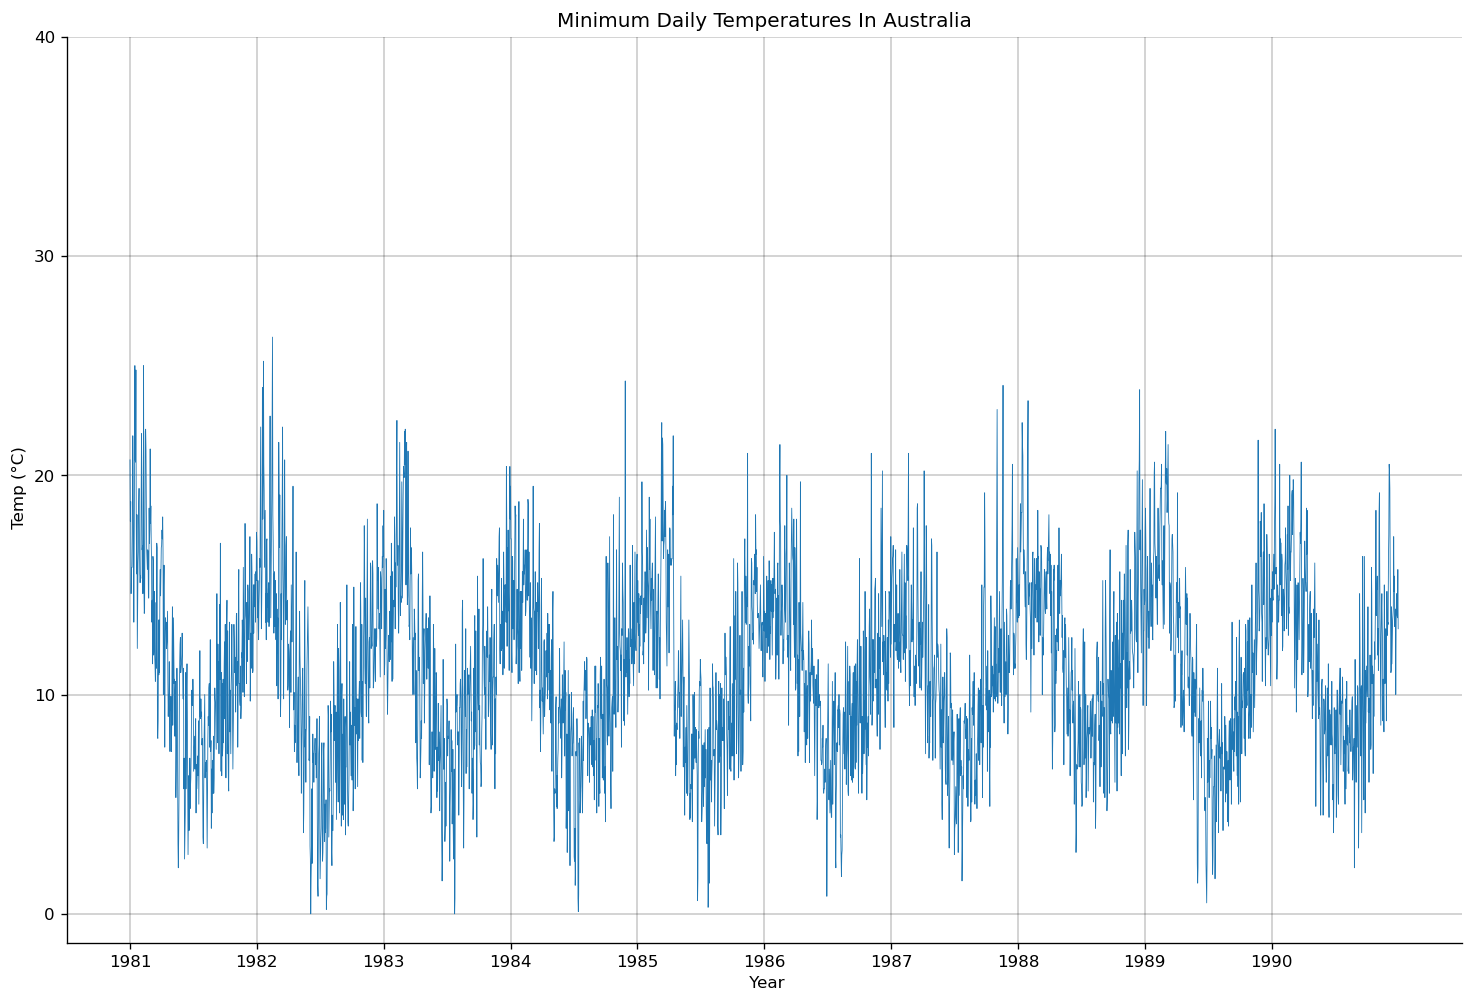

In [17]:
import matplotlib.pyplot as plt

def lineplot(df, x_dim, y_dim, x_ticks, x_ticklabels, y_ticks, y_ticklabels):
    x = df[x_dim]
    y = df[y_dim]
    
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(x, y, linewidth=0.5)

    #add title and axes labels
    ax.set_title('Minimum Daily Temperatures In Australia')
    ax.set_xlabel(' Year')
    ax.set_ylabel(' Temp (°C)')
    
    #setting tick-rate on axes
    ax.set_xticks(x_ticks) 
    ax.set_xticklabels(x_ticklabels)
    
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticklabels)
    
    #removing top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #adds major gridlines
    ax.grid(color='black', linestyle='-', linewidth=0.2, alpha=1)
    
    plt.show()

lineplot(temp_df, 'DATE', 'TEMP', 
         [0, 365, 730, 1095, 1460, 1825, 2190, 2555, 2920, 3285], 
         ['1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990'], 
         [0, 10, 20, 30, 40],
         ['0', '10', '20' ,'30' ,'40'])

## Introduction to Time Series Forecasting Algorithms

For a start, what does ARIMA even mean?

ARIMA is an acronym for 'Auto Regressive Integrated Moving Avarage'. In short, it is a class of models which predicts a given time series based on its own past values. 

Any non-seasonal time series that exhibits patterns and is not randomly generated white noise can be modeled with ARIMA models.

An ARIMA model has 3 terms: _p_, _d_ and _q_

* p - order of AR
* q - order of MA
* d - differencing necessary to make times series stationary

If a time series has seasonal patterns, then seasonal terms have to be added and it becomes: SARIMA, short for Seasonal ARIMA.

### What is the meaning of _p_, _q_ and _d_?

One of the first steps to building an ARIMA model is making the time series stationary. Because the term 'Auto Regressive' in ARIMA it means this algorithm is a _linear regression model_ that uses its own lags as predictors.

**Linear regression models work best when the predictors are not correlated and independent of each other**

One of the main ways of making a series stationary is to difference it. As in subtract the previous value from the current value. Depending on the complexity, more than one differencing might be needed.

therefore, the value of _d_ is the minimum number of differencing needed to make the series stationary. If the series is already stationary then d=0.

_p_ is the Auto Regressive (AR) term. It specifies the number of lags of Y to be used as predictors. 

_q_ is the Moving Avarage (MA) term. It refers to the number of lagged forecast errors that should be incorporated in the model.

### What are the AR and MA models?

A pure Auto Regressive model is one where _Yt_ depends only on its own lags.

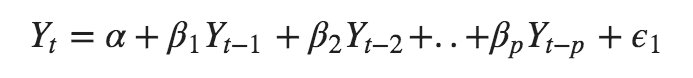

where, $Y{t-1}$ is the lag1 of the series, $\beta1$ is the coefficient of lag1 that the model estimates and $\alpha$ is the intercept term, also estimated by the model.

Just like a pure AR model, a pure Moving Avarage (MA) model is one where _Yt_ depends only on the lagged forecast errors.

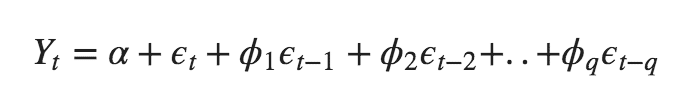

The error terms are the errors of the AR models on the respective lags.

To sum everything up, what is the equation of an ARIMA model?

As noted before, an ARIMA model is differenced at least once to make it stationary and then a combination of AR and MA terms is applied.

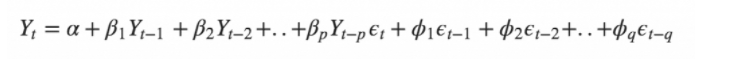

In other words: Predicted _Yt_ = _Constant_ + _Linear combination lags of Y (up to p lags)_ + _Linear combination of lagged forecast errors (up to q lags)

Therefore the objective of making an ARIMA model can be constructed as identifying the values of **p**, **d** and **q**

### Autocorrelation Plot

Datasets for prediciting future values can be categorized into 2 groups.

1. A Time Series refers to observations of a specific variable over a specified time. For example the avarage daily temperature over the past 10 years.
2. Cross-sectional data refers to observations of many variables at a single point in time.

An autocorellation plot shows whether the elements of a time series are positively correlated, negatively correlated or independent of eachother.

The plot shows the value of the autocorellation function on the vertical axis. It ranges from 1 to -1

On the horizontal axis of the plot the size of lag between the elements is displayed. i.e. the autocorrelation with lag _x_ is the correlation between the time series elements and the corresponding elements that were observed _x_ time periods earlier.

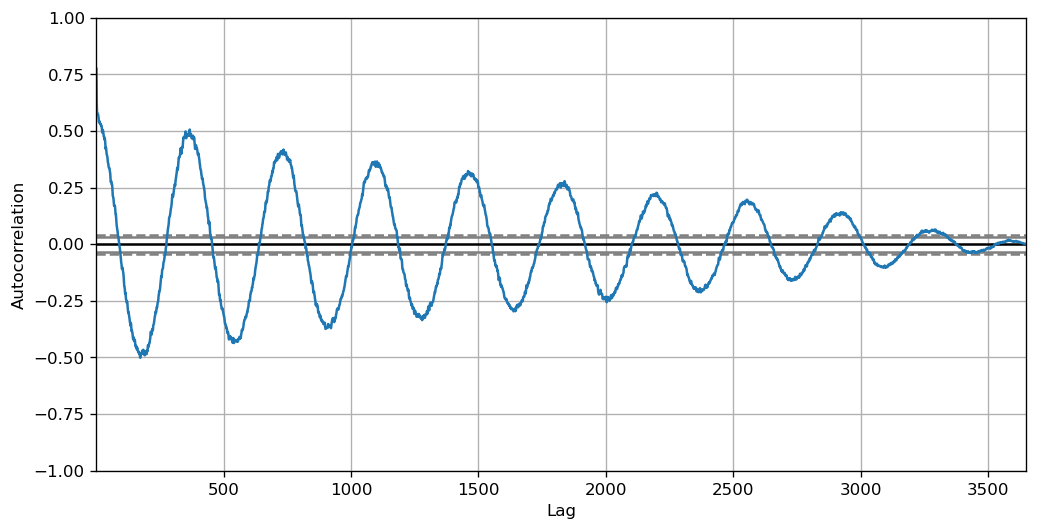

In [18]:
from pandas.plotting import autocorrelation_plot
from datetime import datetime

def parser(x):
    return datetime.strptime(''+x, '%Y-%m-%d')

series = pd.read_csv('/Users/matt/Desktop/AI/PersonalNotebooks/ML/TimeSeriesForecasting/daily-min-temperatures.csv',
                 header=0,
                 parse_dates=[0],
                 index_col=0,
                 squeeze=True,
                 date_parser=parser)

plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
autocorrelation_plot(series)
plt.show()

## Machine Learning

For time series forecasting there are several algorithms which can be applied. In this notebook a comparison will be made between ARIMA, SARIMA and SARIMAX.